# Connecting with Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Change working directory
%cd '/content/drive/MyDrive/Colab Notebooks/deep_acelerometry'

/content/drive/MyDrive/Colab Notebooks/deep_acelerometry


# Setup

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Check that we are using GPU
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

### 1. Load target labels

In [5]:
target = pd.read_csv('target.csv')

In [ ]:
target

,SEQN,DXXNK_TSCORE,CLASSES,TARGET_BINARY
0,73557.0,NaN,NaN,NaN
1,73558.0,-0.358333,normal,0.0
2,73559.0,NaN,NaN,NaN
3,73561.0,-1.133333,osteopenia,1.0
4,73562.0,0.316667,normal,0.0
...,...,...,...,...
3703,83721.0,-0.266667,normal,0.0
3704,83723.0,1.191667,normal,0.0
3705,83724.0,NaN,NaN,NaN
3706,83726.0,0.841667,normal,0.0


### 2. Load relevant features for classification: gender, age and body mass.

In [6]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')

In [ ]:
X_train.shape, X_test.shape

((2003, 9), (501, 9))

In [ ]:
X_train.iloc[:,:4]

,SEQN,RIAGENDR,RIDAGEYR,BMXWT
0,76988.0,1.0,67.0,68.3
1,82083.0,2.0,57.0,67.4
2,75435.0,2.0,63.0,60.3
3,76741.0,2.0,68.0,70.1
4,78834.0,2.0,56.0,57.1
...,...,...,...,...
1998,74345.0,1.0,56.0,79.2
1999,82126.0,1.0,56.0,70.5
2000,78475.0,2.0,77.0,71.7
2001,74862.0,2.0,48.0,66.1


In [7]:
# Combine them into a single DataFrame
features_df = pd.concat([X_train.iloc[:,:4], X_test.iloc[:,:4]]).reset_index(drop=True)

In [8]:
features_df

,SEQN,RIAGENDR,RIDAGEYR,BMXWT
0,76988.0,1.0,67.0,68.3
1,82083.0,2.0,57.0,67.4
2,75435.0,2.0,63.0,60.3
3,76741.0,2.0,68.0,70.1
4,78834.0,2.0,56.0,57.1
...,...,...,...,...
2499,79610.0,2.0,66.0,74.3
2500,77717.0,1.0,48.0,131.7
2501,75946.0,2.0,71.0,92.4
2502,75081.0,2.0,66.0,64.7


### 3. Physical activity data (tensors with GAF images)

Choose sampling frequency, which determines image size

In [9]:
#directory = '/content/drive/MyDrive/Colab Notebooks/deep_acelerometry/tensors_288' # 1 sample every 5 minutes
directory = '/content/drive/MyDrive/Colab Notebooks/deep_acelerometry/tensors_144' # 1 sample every 10 minutes
image_size = int(directory.split('_')[2])

# Filenames are read and split them into training and validation sets accordingly.
all_files = os.listdir(directory)
train_files = [f for f in all_files if 'train' in f]
test_files = [f for f in all_files if 'test' in f]


In [ ]:
image_size

144

In [ ]:
len(train_files)

2003

In [ ]:
len(test_files)

501

# Data generator

### Step 1: Define the Generator Class
You'll subclass tf.keras.utils.Sequence to ensure your generator handles batch processing and shuffling properly.

In [10]:
class DataGenerator(Sequence):
    def __init__(self, directory, file_list, target_df, features_df, batch_size=32, shuffle=True):
        self.directory = directory
        self.file_list = file_list
        self.target_df = target_df
        self.features_df = features_df  # Add this to handle the external features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        return self.__load_data(batch_files)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_data(self, batch_files):
        'Loads data for a batch'
        x = []
        y = []
        features = []
        for file_name in batch_files:
            file_path = os.path.join(self.directory, file_name)
            data = np.load(file_path)
            x.append(data)
            subject_id = float(file_name.split('_')[1])
            # Retrieve target label
            target_label = self.target_df[self.target_df['SEQN'] == subject_id]['TARGET_BINARY'].iloc[0]
            y.append(target_label)
            # Retrieve additional features
            feature_row = self.features_df[self.features_df['SEQN'] == subject_id][['RIAGENDR', 'RIDAGEYR', 'BMXWT']]
            if not feature_row.empty:
                features.append(feature_row.iloc[0].values)
            else:
                # Handle cases where no features are found
                features.append(np.array([np.nan, np.nan, np.nan]))  # Assuming NaNs as placeholders

        return ([np.array(x), np.array(features)], np.array(y))



### Step 2: Instantiate the Data Generator
Now you can create instances of DataGenerator for both training and validation.

In [11]:
batch_size = 32  # You can adjust this based on your GPU capacity and training needs

# Create instances of DataGenerator for training and testing
train_generator = DataGenerator(directory=directory, file_list=train_files, target_df=target, features_df=features_df, batch_size=batch_size, shuffle=True)
test_generator = DataGenerator(directory=directory, file_list=test_files, target_df=target, features_df=features_df, batch_size=batch_size, shuffle=False)


Just to see an example of the content:

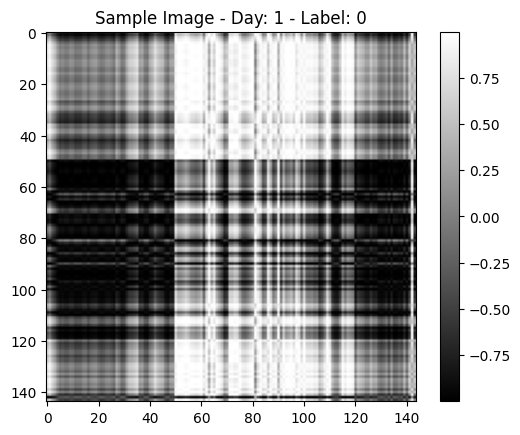

In [ ]:
# Fetch the first batch of data
x_batch, y_batch = train_generator.__getitem__(0)

# Select the first tensor from the batch
sample_tensor = x_batch[0]

# Assuming you want to plot the first channel of the tensor
channel_number = 0
plt.imshow(sample_tensor[:, :, channel_number], cmap='gray')
plt.title(f'Sample Image - Day: {channel_number + 1} - Label: {int(y_batch[0])}')
plt.colorbar()
plt.show()

# Compile and train

**Modelo 1)** 5 veces Conv2D + BatchNormalization + MaxPooling

In [ ]:
# Define the input layer for the images
image_input = Input(shape=(image_size, image_size, 7))
# Define the input layer for the additional features
features_input = Input(shape=(3,))

# CNN layers - making the network deeper and more complex
nof_filters = 64  # Increased the number of filters
x = Conv2D(nof_filters, (3, 3), activation='relu', padding='same')(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(nof_filters * 2, (3, 3), activation='relu', padding='same')(x)  # Second Conv layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(nof_filters * 4, (3, 3), activation='relu', padding='same')(x)  # Third Conv layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(nof_filters * 8, (3, 3), activation='relu', padding='same')(x)  # Fourth Conv layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(nof_filters * 16, (3, 3), activation='relu', padding='same')(x)  # Fifth Conv layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)  # Increased dropout rate after more layers
x = Flatten()(x)

# Concatenate CNN output and additional features
x = Concatenate()([x, features_input])

# Dense layers
nof_neurons = 64  # Increased neurons
x = Dense(nof_neurons, activation='relu')(x)
x = Dropout(0.3)(x)  # Increased dropout rate in dense layer
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[image_input, features_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[early_stopping])


Epoch 1/20
62/62 [==============================] - 27s 337ms/step - loss: 0.7867 - accuracy: 0.5222 - val_loss: 0.7105 - val_accuracy: 0.4792
Epoch 2/20
62/62 [==============================] - 19s 310ms/step - loss: 0.7100 - accuracy: 0.5817 - val_loss: 1.1825 - val_accuracy: 0.6104
Epoch 3/20
62/62 [==============================] - 21s 333ms/step - loss: 0.6886 - accuracy: 0.5958 - val_loss: 1.0371 - val_accuracy: 0.6104
Epoch 4/20
62/62 [==============================] - 19s 312ms/step - loss: 0.6667 - accuracy: 0.6139 - val_loss: 0.7699 - val_accuracy: 0.6104
Epoch 5/20
62/62 [==============================] - 21s 341ms/step - loss: 0.6593 - accuracy: 0.6245 - val_loss: 0.6574 - val_accuracy: 0.6125
Epoch 6/20
62/62 [==============================] - 20s 316ms/step - loss: 0.6527 - accuracy: 0.6230 - val_loss: 0.6457 - val_accuracy: 0.6187
Epoch 7/20
62/62 [==============================] - 19s 310ms/step - loss: 0.6308 - accuracy: 0.6593 - val_loss: 0.6753 - val_accuracy: 0.6208

**Modelo 2)** ResNet
- Intenté en lugar ResNet preentrenado para ImageNet (transfer learning), pero tiene una serie de restricciones que lo complican, como el hecho de que admite sólo 3 canales, y no 7.

In [12]:
def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x
    if downsample:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def tfm_resnet(input_shape, additional_features_shape, num_classes):
    image_input = Input(shape=input_shape)
    features_input = Input(shape=additional_features_shape)

    # Initial convolution
    x = Conv2D(64, (7, 7), strides=2, padding='same')(image_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # ResNet blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2, downsample=True)  # downsample
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2, downsample=True)  # downsample
    x = residual_block(x, 256)

    # Global Pooling and output layer for image features
    x = GlobalAveragePooling2D()(x)

    # Concatenate CNN output and additional features
    x = Concatenate()([x, features_input])

    # Dense layers and final classification layer
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(num_classes, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=[image_input, features_input], outputs=output)
    return model

# Set up and compile the model
model = tfm_resnet(input_shape=(image_size, image_size, 7), additional_features_shape=(3,), num_classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the data generators
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[early_stopping])


Epoch 1/20
62/62 [==============================] - 74s 872ms/step - loss: 0.6527 - accuracy: 0.6401 - val_loss: 11.1625 - val_accuracy: 0.3917
Epoch 2/20
62/62 [==============================] - 30s 493ms/step - loss: 0.5985 - accuracy: 0.6915 - val_loss: 2.8748 - val_accuracy: 0.4042
Epoch 3/20
62/62 [==============================] - 22s 355ms/step - loss: 0.5787 - accuracy: 0.7036 - val_loss: 0.5681 - val_accuracy: 0.6958
Epoch 4/20
62/62 [==============================] - 19s 309ms/step - loss: 0.5845 - accuracy: 0.7056 - val_loss: 0.5881 - val_accuracy: 0.6833
Epoch 5/20
62/62 [==============================] - 21s 339ms/step - loss: 0.5641 - accuracy: 0.7213 - val_loss: 0.8726 - val_accuracy: 0.5646
Epoch 6/20
62/62 [==============================] - 21s 334ms/step - loss: 0.5651 - accuracy: 0.7188 - val_loss: 0.7462 - val_accuracy: 0.6021
Epoch 7/20
62/62 [==============================] - 21s 341ms/step - loss: 0.5449 - accuracy: 0.7298 - val_loss: 0.7535 - val_accuracy: 0.585

Los valores obtenidos son similares a los que observé usando algoritmos "clásicos" de machine learning para clasificación. No observo mejora por el hecho de usar deep learning.

**Modelo 3:** VGG

In [13]:
# Define the input layer for the images
image_input = Input(shape=(image_size, image_size, 7), name='image_input')
# Define the input layer for the additional features
features_input = Input(shape=(3,), name='features_input')

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(image_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Flatten and concatenate additional features
x = Flatten(name='flatten')(x)
x = Concatenate()([x, features_input])

# Dense Classification Block
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)  # Incorporating dropout for regularization
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)  # Incorporating dropout for regularization
output = Dense(1, activation='sigmoid', name='predictions')(x)  # Adjust the output units and activation for binary classification

# Create the model
model = Model(inputs=[image_input, features_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model summary to check architecture
model.summary()

# Training the model with early stopping
history = model.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[early_stopping])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 144, 144, 7)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 144, 144, 64)         4096      ['image_input[0][0]']         
                                                                                                  
 block1_conv2 (Conv2D)       (None, 144, 144, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 72, 72, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

Esta arquitectura parece que ha conseguido un rendimiento (ligeramente) superior. En cualquier caso, no ha superado el rendmiento de los algoritmos de machine learning, que era una de las hipótesis a testar.